In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
import pickle

%matplotlib inline

In [2]:
USED_SAVED_MODEL = True

In [3]:
def saveModel(model,filename):
    pickle.dump(model, open(filename, 'wb'))

def loadModel(filename):
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

In [4]:

def readData(filepath):
    ds = pd.read_csv(filepath)
    data = ds.values
    xtrain = data[:,0:-1]
    ytrain = data[:,-1]
    
    # Normalize the Data, Scale the Values between 0,1
    xtrain = np.asarray(xtrain)
    xtrain = (xtrain/255.0)
    return xtrain,ytrain



In [5]:
filepath = './mnist/train.csv'
xtrain,ytrain = readData(filepath)

9


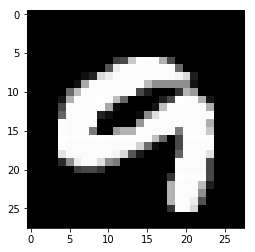

In [108]:
def printImage(i,xtrain,ytrain):
    """Prints the i th row and label from dataset
    Args:
        Accepts an integer i, the row number
    Outputs:
        Image and Label
    """
    image = xtrain[i]
    label = ytrain[i]
    
    print(label)
    img = image.reshape((28,28))
    plt.figure(i)
    plt.imshow(img,cmap='gray')
    plt.show()
    
    
    
printImage(4,xtrain,ytrain)



#print(xtrain.shape)

In [7]:
class SVM:
    
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.B = 0
        
    def hingeLoss(self,w,b,x,y):
        loss =  0
        loss += 0.5*np.dot(w,w.T)
        m = x.shape[0]
        for i in range(m):
            ti = y[i]*(np.dot(w,x[i].T)+ b)
            loss += self.C*max(0,(1-ti))
        return loss[0][0]
                
    def solve(self,x,y,batch_size=100,max_iter =100,solver="Pegasos",learning_rate=0.001):
        
        if(solver=="Pegasos"):
            no_of_features = x.shape[1]
            no_of_samples = x.shape[0]
            n = learning_rate
            c = self.C
            w = np.zeros((1,no_of_features))
            bias = 0
            losses = []
            # Apply the Gradient Update Rule
            for t in range(max_iter):
                #l = self.hingeLoss(w,bias,x,y)
                
                #losses.append(l)  
                indexes = np.arange(no_of_samples)
                np.random.shuffle(indexes)
                
                for b in range(0,no_of_samples,batch_size): 
                    gradw = 0
                    gradb = 0
                    for j in range(b,b+batch_size):
                        if(j<no_of_samples):
                            i  = indexes[j]
                            ti = y[i]*(np.dot(w,x[i].T)+bias) 
                            if ti>1:
                                gradw += 0
                                gradb += 0
                            else:
                                gradw += c*y[i]*x[i]
                                gradb += c*y[i]
                    w = w - n*w + n*gradw
                    bias = bias + n*gradb
                
            self.W = w
            self.B = bias
            return w,bias #,losses

In [8]:
def classWiseData(xtrain,ytrain):
    """Create a Dictionary of Labels
        Each label is mapped with a numpy array of that dataset
    """
    data = {}
    for i in range(10):
        data[i] = []
    
    for i in range(xtrain.shape[0]):
        data[ytrain[i]].append(xtrain[i])
   
    for key in data.keys():
        temp = data[key]
        data[key] = np.asarray(temp)
        
    return data

In [9]:
data = classWiseData(xtrain,ytrain)
len(data[0][2])
print(data[1].shape[1])


784


In [10]:
print(data[2].shape)

(2000, 784)


In [11]:
def getDataPairForSVM(d1,d2):
    l1,l2 = d1.shape[0],d2.shape[0]
    
    no_of_samples = l1+l2
    no_of_features = d1.shape[1]
    
    dataPair = np.zeros((no_of_samples,no_of_features))
    dataLabels = np.zeros((no_of_samples,))
    
    dataPair[:l1,: ] = d1
    dataLabels[:l1] = -1
    dataPair[l1: ,:] = d2
    dataLabels[l1:] = +1
    
    return dataPair,dataLabels



In [51]:
#xnew,ynew = getDataPairForSVM(data[2],data[3])
#print(xnew.shape)
#print(ynew[1980:2020])

In [50]:
#xnew,ynew = getDataPairForSVM(data[5],data[7])
#meri_svm = SVM()
#w,b = meri_svm.solve(xnew,ynew)
#print(w,b)
#print(w.shape)
#print(b)

In [14]:
def binaryPredict(x,w,b):
    
    z = np.dot(w,x.T) + b
    if z>=0:
        return 1
    else:
        return -1


   

In [15]:
mySVM = SVM()

def trainSVMs(xtrain,ytrain):
    svm_classifiers = {} 

    for i in range(10):
        svm_classifiers[i] = {}
        for j in range(i+1,10):
                xpair,ypair =getDataPairForSVM(data[i],data[j])
                wts,b= mySVM.solve(xpair,ypair)
                svm_classifiers[i][j] = (wts,b)
    
    return svm_classifiers



if USED_SAVED_MODEL == False:
    svm_classifiers = trainSVMs(xtrain,ytrain)
    saveModel(svm_classifiers,'svm_mnist.pickle')
    print("Model Saved Successfully")
else:
    svm_classifiers = loadModel('svm_mnist.pickle')
    print("Model Loaded Successfully")


Model Loaded Successfully


In [16]:
def predict(x):
    """Prediction using One Vs One Strategy"""
    count = np.zeros((10,))
    
    for i in range(10):
        for j in range(i+1,10):
                w,b = svm_classifiers[i][j]
                z = binaryPredict(x,w,b)
                "Higher value(+1) is mapped with j,and Lower Value(-1) is mapped with i"
                if(z==1):
                    count[j] +=1 
                else:
                    count[i] +=1 
            
    #print(count)
    finalAns = 0
    for j in range(0,10):
        if(count[j]>=count[finalAns]):
            finalAns = j
            
    return finalAns
    

In [52]:
#predict(xtrain[4])

In [18]:
def accuracy(x,y):
    count = 0
    
    for i in range(x.shape[0]):    
        predicted_label = predict(x[i])
        if(predicted_label==y[i]):
            count +=1
    
    return count/x.shape[0]


        

In [19]:
accu_train = accuracy(xtrain,ytrain)
print(accu_train)

0.9509475473773689


In [20]:
filepathTest = './mnist/test.csv'
xtest,ytest = readData(filepathTest)

accu_test = accuracy(xtest,ytest)

In [21]:
print(accu_test)

0.9383938393839384


### In the next section, we will implement using SVM using LibSVM


In [25]:
from sklearn import svm


### Linear and Gaussian Kernel SVM 

In [62]:
def linear_gaussian_SVM(x,y,xtest,ytest,retrain=True,kernel='linear'):
    
    if(retrain):    
        if(kernel=='linear'):
            svm_clf = svm.SVC(kernel='linear',C=1.0)
            svm_clf.fit(x, y)
            saveModel(svm_clf,'linearSVM.pickle')

        elif(kernel=='gaussian'):
            svm_clf = svm.SVC(kernel='rbf',C=1.0,gamma=0.05)
            svm_clf.fit(x, y)
            saveModel(svm_clf,'gaussianSVM.pickle')
    
    else:
        if(kernel=='linear'):
            svm_clf = loadModel('linearSVM.pickle')
        elif(kernel=='gaussian'):
            svm_clf = loadModel('gaussianSVM.pickle')
        

   
    train_accuracy = svm_clf.score(x,y)
    test_accuracy = svm_clf.score(xtest,ytest)
    
    return train_accuracy,test_accuracy




In [57]:
train_linear_acc,test_linear_acc = linear_gaussian_SVM(xtrain,ytrain,xtest,ytest)


In [69]:
print("Linear Kernel \nTrain Acc: %.4f \nTest Acc: %.4f"%(train_linear_acc,test_linear_acc))


Linear Kernel 
Train Acc: 0.9879 
Test Acc: 0.9283


In [63]:
train_gaussian_acc,test_gaussian_acc = linear_gaussian_SVM(xtrain,ytrain,xtest,ytest,retrain=True,kernel="gaussian")


In [71]:
print("Gaussian Kernel \nTrain Acc: %.4f \nTest Acc: %.4f"%(train_gaussian_acc,test_gaussian_acc))


Gaussian Kernel 
Train Acc: 0.9992 
Test Acc: 0.9724


# 10 Fold Cross Validation over various C Values

In [26]:
from sklearn.model_selection import cross_val_score

In [72]:
def GaussianSVM(x,y,xtest,ytest,c,reTrain=False):
        
        if(reTrain==True):
            gsvm = svm.SVC(kernel='rbf',C=c,gamma=0.05)
            gsvm.fit(x,y)
            filename = "Gaussian_SVM_"+str(c)+".pickle" 
            saveModel(gsvm,filename)
        else:
            filename = "Gaussian_SVM_"+str(c)+".pickle"
            gsvm = loadModel(filename)
        
        scores = cross_val_score(gsvm, x, y,cv=10)
        scores_test = gsvm.score(xtest,ytest)
        
        print("Mean Training Accuracy : %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        return scores.mean(),scores_test

    
penalty = [0.00001,0.001,1,5,10]

In [29]:
trainAcc = []
testAcc = [] 

for c in penalty:
    print("Accuracy for C : %.5f"%c)
    train_accuracy,test_accuracy = GaussianSVM(xtrain,ytrain,xtest,ytest,c)
    trainAcc.append(train_accuracy)
    testAcc.append(test_accuracy)
    print("Training %.4f Testing %.4f\n"%(train_accuracy,test_accuracy))
    

Accuracy for C : 0.00001
Mean Training Accuracy : 0.67 (+/- 0.04)
Training 0.6654 Testing 0.6636

Accuracy for C : 0.00100
Mean Training Accuracy : 0.67 (+/- 0.04)
Training 0.6654 Testing 0.6636

Accuracy for C : 1.00000
Mean Training Accuracy : 0.97 (+/- 0.01)
Training 0.9742 Testing 0.9724

Accuracy for C : 5.00000
Mean Training Accuracy : 0.98 (+/- 0.01)
Training 0.9752 Testing 0.9730

Accuracy for C : 10.00000
Mean Training Accuracy : 0.98 (+/- 0.01)
Training 0.9752 Testing 0.9730



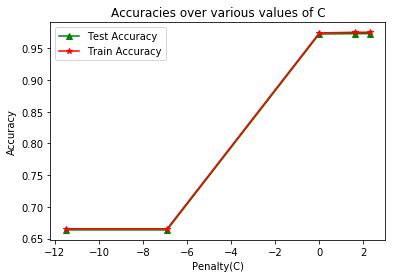

In [99]:
plt.title("Accuracies over various values of C")
plt.plot(np.log(penalty),testAcc,c='g',marker='^',label="Test Accuracy")
plt.plot(np.log(penalty),trainAcc,c='r',marker='*',label="Train Accuracy")
plt.xlabel("Penalty(C)")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [110]:
# Draw the Confusion Matrix for the Best Results
#print(trainAcc)

In [35]:
from pandas_ml import ConfusionMatrix
from matplotlib import pyplot as plt 
%matplotlib inline



Confusion matrix:
Predicted    0     1     2     3    4    5    6     7    8    9  __all__
Actual                                                                  
0          969     0     1     0    0    3    4     1    2    0      980
1            0  1123     3     2    0    2    2     0    2    1     1135
2            4     0  1000     4    2    0    1     6   15    0     1032
3            0     0     8   986    0    4    0     6    5    1     1010
4            1     0     5     0  962    0    4     0    2    8      982
5            2     0     3     6    1  866    7     1    5    1      892
6            5     4     0     0    3    4  940     0    2    0      958
7            1     4    20     2    4    0    0   984    2   10     1027
8            4     0     3    10    2    5    2     3  942    3      974
9            4     4     3     8    9    4    0     9   11  957     1009
__all__    990  1135  1046  1018  983  888  960  1010  988  981     9999


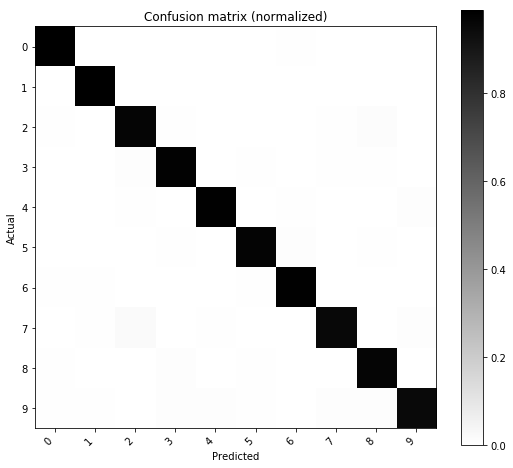

In [42]:
def confMatrix(xtest,ytest):
    best_acc_index = np.argmax(trainAcc)
    best_c = penalty[best_acc_index]
    
    filename = "Gaussian_SVM_"+str(best_c)+".pickle"
    best_gsvm = loadModel(filename)
    
    prediction = best_gsvm.predict(xtest)
    confusion_matrix = ConfusionMatrix(ytest,prediction)
    print("Confusion matrix:\n%s" % confusion_matrix)
    confusion_matrix.plot(normalized=True)
    plt.show()
    return prediction,confusion_matrix
    
prediction,confusion_matrix = confMatrix(xtest,ytest)

In [ ]:
# Misqualify -  2 and 7, 3 and 8, 4 and 9, 6 and 5, 9 and 7

In [47]:
confusion_matrix.classification_report

,precision,recall,F1_score,support
Classes,,,,
0,0.978788,0.988776,0.983756,980
1,0.989427,0.989427,0.989427,1135
2,0.956023,0.968992,0.962464,1032
3,0.968566,0.976238,0.972387,1010
4,0.978637,0.979633,0.979135,982
5,0.975225,0.970852,0.973034,892
6,0.979167,0.981211,0.980188,958
7,0.974257,0.95813,0.966127,1027
8,0.953441,0.967146,0.960245,974


4 misqualifed as 0
4


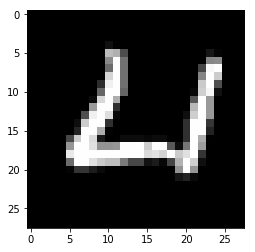

7 misqualifed as 4
7


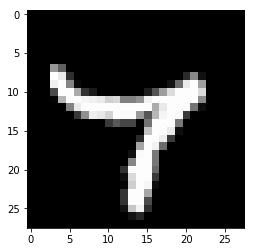

9 misqualifed as 8
9


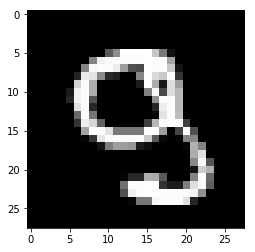

9 misqualifed as 8
9


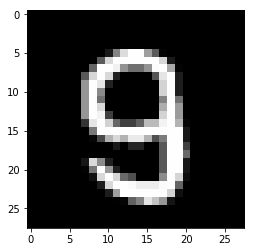

4 misqualifed as 2
4


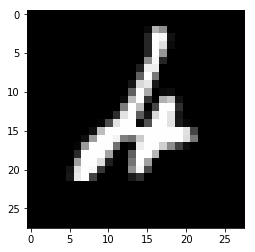

2 misqualifed as 7
2


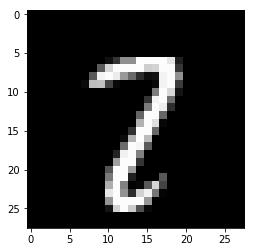

0 misqualifed as 5
0


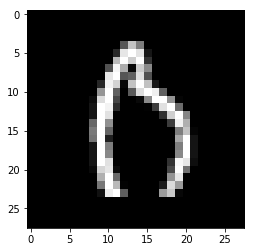

5 misqualifed as 3
5


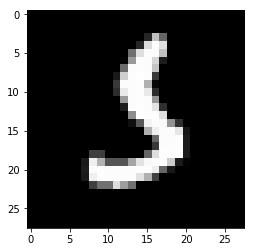

3 misqualifed as 7
3


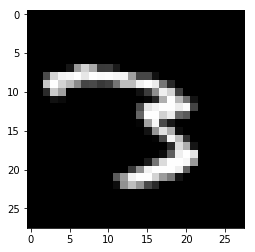

2 misqualifed as 8
2


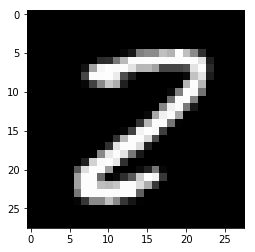

In [109]:
def printMisclassifedExamples(x,yactual,prediction,no_of_examples):
    
    misqualify=0
    
    for i in range(x.shape[0]):
        
        if(yactual[i]!=prediction[i]):
            print("%d misqualifed as %d"%(yactual[i],prediction[i]))
            misqualify += 1
            
            printImage(i,x,yactual)
            
            if misqualify == no_of_examples:
                break
        
        
            
printMisclassifedExamples(xtest,ytest,prediction,10)
    
    